# Pytorch + Pytorch Lightning + Ray Tune

In this notebook, we first train, validate, and predict on Titanic problem using the default `Pytorch` framework.

Next, we update and replace the boilerplate codes using the `Pytorch Lightning` framework.

Last, we combine the `Pytorch Lightning` with the `Ray Tune` (a `Hyperparameter Tuning` framework) to find the best hyperparameters.

# 😺 Basic Pytorch



In [1]:
!pip install sweetviz
import numpy as np
import pandas as pd
import sweetviz as sv
import os
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')
clear_output()

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

In [3]:
from pathlib import Path
data_dir = Path("data")
ckpt_dir = Path("checkpoints")
log_dir = Path("logs")
submission_dir = Path("submissions")

list(data_dir.iterdir())

[PosixPath('data/gender_submission.csv'),
 PosixPath('data/test.csv'),
 PosixPath('data/train.csv')]

## 1  Data Preprocessing

### 1.1 Loading Data

In [4]:
train_data = pd.read_csv(data_dir / "train.csv")
test_data = pd.read_csv(data_dir / "test.csv")

In [5]:
train_data.iloc[:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 1.2 Data Preview

First, we use library `sweetviz` to do a quick data exploration on the titanic dataset.

1. Values in `age` are missing 177 (20%) in `train_data` and 86 (21%) in `test_data`. 
2. Values in `cabin` are missing 687 (77%) and 327 (78%) in both datasets.
3. The features that have the most impact on `Survived` are `Sex` and `Fare`.


                                             |          | [  0%]   00:00 -> (? left)

AttributeError: module 'numpy' has no attribute 'warnings'

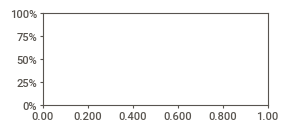

In [6]:
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat="Survived", pairwise_analysis="on")
report.show_notebook()

### 1.3 Data Completing, Data Cleaning, Data Creating

#### Completing

We fill the missing values of `age`, `embarked`, `fare` in both `train_data` and `test_data` with **median** and **mode** respectively.

#### Cleaning

Then we drop the `id`, `cabin`, `ticket` columns from both dataset because:

1. `PassengerId` has no meaning.
2. `Cabin` has too many missing values.
3. `Ticket` has no meaning from its distribution. (maybe)

#### Creating (Feature Engineering)

We extract the information from `SibSp` and `Parch`, then create two new features: `FamilySize` and `IsAlone`.

From the `Name` feature, we can get the `Title` of each person. After the extraction, we can drop the `Name` column.

Finally, we use `qcut()` and `cut()` from pandas, to convert the `Age` and `Fare` into discrete intervals, then we drop the `Age` and `Fare`.

> - [pandas的cut&qcut函數](https://medium.com/@morris_tai/pandas%E7%9A%84cut-qcut%E5%87%BD%E6%95%B8-93c244e34cfc)
> - [pandas的cut，qcut函数的使用和区别](https://zhuanlan.zhihu.com/p/68194655)


In [7]:
data_cleaner = [train_data, test_data]

In [8]:
test_ids = test_data["PassengerId"]

for dataset in data_cleaner:
    # Data Completing
    dataset["Age"].fillna(dataset["Age"].median(), inplace=True)
    dataset["Embarked"].fillna(dataset["Embarked"].mode()[0], inplace=True)
    dataset["Fare"].fillna(dataset["Fare"].median(), inplace = True)

    # Data Cleaning
    drop_column = ['PassengerId', 'Cabin', 'Ticket']
    dataset.drop(drop_column, axis=1, inplace=True)

    # Data Creating (Feature Engineering)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1  #initialize to 1 = is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0  # now update to no if family size is greater than 1

    dataset['Title'] = dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_counts = dataset['Title'].value_counts() < 10
    dataset["Title"] = dataset["Title"].apply(lambda x: "Misc" if title_counts.loc[x] == True else x)

    ## Divide the `Fare` into 4 intervals with similar quantities.
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4, labels=False)

    ## Divide the `Age` into 4 discrete intervals according to its value.
    dataset['AgeBin'] = pd.cut(dataset['Age'], [0, 25, 50, 75, 100], labels=False)

    ## Drop these columns since we have these features in the discrete version.
    dataset.drop(columns=["Name", "Age", "Fare"], inplace=True)

In [9]:
train_data.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
634,0,3,female,3,2,S,6,0,Miss,2,0
446,1,2,female,0,1,S,2,0,Miss,2,0
381,1,3,female,0,2,C,3,0,Miss,2,0
167,0,3,female,1,4,S,6,0,Mrs,2,1
529,0,2,male,2,1,S,4,0,Mr,1,0


### 1.4 Data Labeling

In this step, we have to convert the features: `Sex`, `Title`, and `Embarked` into **discrete form** by using `sklearn.preprocessing.LabelEncoder`.

In [10]:
for dataset in data_cleaner:
    label_encoder = LabelEncoder()
    dataset["Sex"] = label_encoder.fit_transform(dataset["Sex"])
    dataset["Title"] = label_encoder.fit_transform(dataset["Title"])
    dataset["Embarked"] = label_encoder.fit_transform(dataset["Embarked"])

In [11]:
train_data

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
0,0,3,1,1,0,2,2,0,3,0,0
1,1,1,0,1,0,0,2,0,4,3,1
2,1,3,0,0,0,2,1,1,2,1,1
3,1,1,0,1,0,2,2,0,4,3,1
4,0,3,1,0,0,2,1,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,2,1,1,1,1,1
887,1,1,0,0,0,2,1,1,2,2,0
888,0,3,0,1,2,2,4,0,2,2,1
889,1,1,1,0,0,0,1,1,3,2,1


                                             |          | [  0%]   00:00 -> (? left)

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

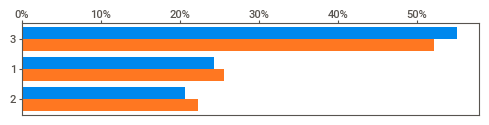

In [12]:
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat="Survived")
report.show_notebook()

In [13]:
y = train_data.pop("Survived")
X = train_data

## 2  Lazypredict Baseline

In [14]:
!pip install lazypredict
clear_output()

In [15]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

def lazy_predict(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models, predictions

lazy_predict(X, y)[0][:10]

100%|██████████| 29/29 [00:00<00:00, 37.90it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.85,0.84,0.84,0.85,0.03
XGBClassifier,0.83,0.82,0.82,0.83,0.06
RandomForestClassifier,0.83,0.82,0.82,0.83,0.11
NuSVC,0.83,0.82,0.82,0.83,0.02
ExtraTreeClassifier,0.82,0.81,0.81,0.82,0.01
SVC,0.82,0.81,0.81,0.82,0.02
Perceptron,0.79,0.81,0.81,0.79,0.01
GaussianNB,0.80,0.81,0.81,0.80,0.01
BaggingClassifier,0.82,0.80,0.80,0.81,0.03


## 3  Hyperparameters

In [16]:
batch_size = 64
lr = 0.1
dropout = 0.3
hidden_size = 512

## 4 Pytorch Dataset Enclosing

In this step, we will get the `X` and `y` from the **dataframe's values** and put them into our custom but redundant (for learning purpose) `torch.utils.data.Dataset`.

After that, we split the `Dataset` into training and validation datasets, load them using `DataLoader` with the contrived `collate_fn` function (for learning purpose again).

In [26]:
X_train = X.values
y_train = y.values
print("train_set shape:", X_train.shape)

X_test = test_data.values
print("test_set shape:", X_test.shape)

feature_size = X_train.shape[-1]
target_size = 2

print(type(X_train), type(y_train), type(X_test))

train_set shape: (891, 10)
test_set shape: (418, 10)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [18]:
# Same as torch.utils.data.TensorDataset
class MyTensorDataset(Dataset):
    def __init__(self, X, y=None):
        if y is None:
            self.data = X
        else:
            self.data = list(zip(X, y))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

In [19]:
train_dataset = MyTensorDataset(X_train, y_train)
test_dataset = MyTensorDataset(X_test)

train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])


def contrived_fn(batch_data):
    """
    Simulate the behavior of the default collate_fn.
    The return values must be tensor type.
    """
    tensor_X = []
    tensor_y = []
    for x, y in batch_data:
        tensor_X.append(x)
        tensor_y.append(y)
    
    return torch.FloatTensor(tensor_X), torch.LongTensor(tensor_y)


train_loader = DataLoader(train_set, batch_size, True, num_workers=0, collate_fn=contrived_fn)
val_loader = DataLoader(val_set, batch_size, num_workers=0, collate_fn=contrived_fn)
test_loader = DataLoader(test_dataset, batch_size, num_workers=0)

## 5 Network

In [20]:
class Net(nn.Module):
    def __init__(self, feature_size, target_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(feature_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, target_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [21]:
model = Net(feature_size=feature_size, target_size=target_size)
model

Net(
  (fc1): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## 6 Train

### 6.1 Train Functions

In [22]:
def run_step(model, opt, dev, criterion, batch_X, batch_y, training=True):
    batch_X = batch_X.to(dev)
    batch_y = batch_y.to(dev)

    batch_pred = model(batch_X)
    loss = criterion(batch_pred, batch_y)
    acc = (batch_pred.max(1)[1] == batch_y).sum().item()

    if training:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return batch_pred, loss, acc


def run_epoch(model, opt, dev, criterion, data_loader, training=True):
    if training:
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0
    epoch_acc = 0

    for batch_X, batch_y in tqdm(data_loader):
        _, step_loss, step_acc = run_step(model, opt, dev, criterion, batch_X, batch_y, training)
        epoch_loss += step_loss
        epoch_acc += step_acc

    epoch_loss = (epoch_loss / len(data_loader)).item()
    epoch_acc = (epoch_acc / len(data_loader.dataset)) * 100
    return epoch_loss, epoch_acc

### 6.2 Define optimizer, loss, device

In [23]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 6.3 Train with validation

In [24]:
ckpt_dir.mkdir(exist_ok=True, parents=True)
log_dir.mkdir(exist_ok=True, parents=True)

In [25]:
epoch = 50
model.to(dev)

train_loss = []
train_acc = []
eval_loss = []
eval_acc = []

min_loss = np.inf

for i in range(epoch):
    epoch_train_loss, epoch_train_acc = run_epoch(model, opt, dev, criterion, train_loader, training=True)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    with torch.no_grad():
        epoch_eval_loss, epoch_eval_acc = run_epoch(model, opt, dev, criterion, val_loader, training=False)
        eval_loss.append(epoch_eval_loss)
        eval_acc.append(epoch_eval_acc)

    if epoch_eval_loss < min_loss:
        min_loss = epoch_eval_loss
        torch.save(model.state_dict(), ckpt_dir / "model.pt")

    print(f"Epoch {i+1}: \ntrain=loss: {epoch_train_loss}, acc: {epoch_train_acc}\nvalidation=loss: {epoch_eval_loss}, acc: {epoch_eval_acc}")

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: 
train=loss: 2.006524085998535, acc: 60.25280898876404
validation=loss: 1.7504565715789795, acc: 39.10614525139665


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2: 
train=loss: 1.0889008045196533, acc: 63.62359550561798
validation=loss: 0.5849316120147705, acc: 74.86033519553072


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3: 
train=loss: 0.7252415418624878, acc: 69.10112359550563
validation=loss: 0.8121548891067505, acc: 65.36312849162012


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4: 
train=loss: 0.5551726818084717, acc: 74.43820224719101
validation=loss: 0.8381446599960327, acc: 55.865921787709496


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5: 
train=loss: 0.5983578562736511, acc: 72.6123595505618
validation=loss: 0.5088777542114258, acc: 75.41899441340783


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6: 
train=loss: 0.5431973934173584, acc: 74.15730337078652
validation=loss: 0.4015265107154846, acc: 82.68156424581005


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7: 
train=loss: 0.5123043656349182, acc: 78.23033707865169
validation=loss: 0.4058505892753601, acc: 81.00558659217877


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8: 
train=loss: 0.4745626449584961, acc: 78.51123595505618
validation=loss: 0.4895879626274109, acc: 77.6536312849162


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9: 
train=loss: 0.4914957880973816, acc: 77.6685393258427
validation=loss: 0.43412524461746216, acc: 81.00558659217877


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10: 
train=loss: 0.4435923099517822, acc: 78.65168539325843
validation=loss: 0.48973220586776733, acc: 75.97765363128491


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11: 
train=loss: 0.45681285858154297, acc: 78.93258426966293
validation=loss: 0.4324902892112732, acc: 80.44692737430168


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12: 
train=loss: 0.4825836420059204, acc: 80.0561797752809
validation=loss: 0.432873010635376, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13: 
train=loss: 0.43816566467285156, acc: 80.75842696629213
validation=loss: 0.38897860050201416, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14: 
train=loss: 0.4397934377193451, acc: 81.60112359550563
validation=loss: 0.6723465919494629, acc: 55.3072625698324


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15: 
train=loss: 0.48244088888168335, acc: 78.79213483146067
validation=loss: 0.44477254152297974, acc: 82.68156424581005


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16: 
train=loss: 0.4469827115535736, acc: 80.19662921348315
validation=loss: 0.38143643736839294, acc: 83.79888268156425


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17: 
train=loss: 0.4347839057445526, acc: 81.74157303370787
validation=loss: 0.5869804620742798, acc: 75.41899441340783


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18: 
train=loss: 0.4832499921321869, acc: 78.51123595505618
validation=loss: 0.3807239532470703, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19: 
train=loss: 0.43270933628082275, acc: 80.6179775280899
validation=loss: 0.4542528986930847, acc: 77.6536312849162


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20: 
train=loss: 0.428946316242218, acc: 81.8820224719101
validation=loss: 0.44689029455184937, acc: 77.09497206703911


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21: 
train=loss: 0.43209999799728394, acc: 81.03932584269663
validation=loss: 0.47216999530792236, acc: 78.77094972067039


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22: 
train=loss: 0.4348619878292084, acc: 81.32022471910112
validation=loss: 0.5367445349693298, acc: 74.86033519553072


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23: 
train=loss: 0.4279807209968567, acc: 81.17977528089888
validation=loss: 0.4100843369960785, acc: 81.00558659217877


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24: 
train=loss: 0.4314398765563965, acc: 80.89887640449437
validation=loss: 0.4652714133262634, acc: 78.77094972067039


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25: 
train=loss: 0.4218638837337494, acc: 81.17977528089888
validation=loss: 0.38752639293670654, acc: 84.35754189944134


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26: 
train=loss: 0.44300493597984314, acc: 81.03932584269663
validation=loss: 0.44375020265579224, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27: 
train=loss: 0.47068652510643005, acc: 83.56741573033707
validation=loss: 0.6789683699607849, acc: 52.513966480446925


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28: 
train=loss: 0.431474894285202, acc: 78.79213483146067
validation=loss: 0.3729313313961029, acc: 84.91620111731844


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29: 
train=loss: 0.4168885350227356, acc: 83.42696629213484
validation=loss: 0.42288026213645935, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30: 
train=loss: 0.4470941424369812, acc: 80.47752808988764
validation=loss: 0.4208487868309021, acc: 80.44692737430168


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31: 
train=loss: 0.45203256607055664, acc: 82.02247191011236
validation=loss: 0.4931161403656006, acc: 81.00558659217877


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32: 
train=loss: 0.42137426137924194, acc: 81.8820224719101
validation=loss: 0.3928701877593994, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33: 
train=loss: 0.41526252031326294, acc: 82.02247191011236
validation=loss: 0.41332119703292847, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34: 
train=loss: 0.4051290452480316, acc: 81.03932584269663
validation=loss: 0.37764808535575867, acc: 83.79888268156425


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35: 
train=loss: 0.42759668827056885, acc: 83.56741573033707
validation=loss: 0.5511665344238281, acc: 74.30167597765363


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36: 
train=loss: 0.4085513949394226, acc: 81.74157303370787
validation=loss: 0.4081360995769501, acc: 84.35754189944134


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37: 
train=loss: 0.39946573972702026, acc: 82.02247191011236
validation=loss: 0.3742305040359497, acc: 84.35754189944134


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38: 
train=loss: 0.440721720457077, acc: 82.58426966292134
validation=loss: 0.4362954795360565, acc: 81.56424581005587


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39: 
train=loss: 0.4225439429283142, acc: 82.02247191011236
validation=loss: 0.4005145728588104, acc: 82.68156424581005


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40: 
train=loss: 0.40701040625572205, acc: 81.60112359550563
validation=loss: 0.4483787715435028, acc: 77.6536312849162


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41: 
train=loss: 0.4146975874900818, acc: 83.14606741573034
validation=loss: 0.39293229579925537, acc: 82.68156424581005


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42: 
train=loss: 0.45248183608055115, acc: 82.30337078651685
validation=loss: 0.40336930751800537, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43: 
train=loss: 0.43127506971359253, acc: 83.42696629213484
validation=loss: 0.39710110425949097, acc: 83.24022346368714


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44: 
train=loss: 0.4160569906234741, acc: 82.4438202247191
validation=loss: 0.4289013743400574, acc: 80.44692737430168


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45: 
train=loss: 0.44283658266067505, acc: 81.32022471910112
validation=loss: 0.48410463333129883, acc: 79.3296089385475


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46: 
train=loss: 0.40815186500549316, acc: 81.8820224719101
validation=loss: 0.3760263919830322, acc: 85.47486033519553


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47: 
train=loss: 0.39618009328842163, acc: 83.42696629213484
validation=loss: 0.4116494655609131, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48: 
train=loss: 0.4150922894477844, acc: 81.32022471910112
validation=loss: 0.4730305075645447, acc: 78.77094972067039


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49: 
train=loss: 0.4332922697067261, acc: 80.75842696629213
validation=loss: 1.0439456701278687, acc: 70.39106145251397


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50: 
train=loss: 0.5095878839492798, acc: 80.47752808988764
validation=loss: 0.8091109991073608, acc: 64.24581005586593


## 7 Predict

In [26]:
model.load_state_dict(torch.load(ckpt_dir / "model.pt"))
model.eval()

Net(
  (fc1): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [27]:
result = []

with torch.no_grad():
    for X_test_batch in test_loader:
        X_test_batch = X_test_batch.to(dev)
        pred = model(X_test_batch.float())
        pred = pred.max(1)[1]
        result.extend(pred.tolist())

submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': result})

In [28]:
submission_dir.mkdir(exist_ok=True, parents=True)
submission.to_csv(submission_dir / "torch_submission.csv", index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# 😸 Pytorch Lightning

* [PYTORCH LIGHTNING DOCUMENTATION](https://pytorch-lightning.readthedocs.io/en/stable/)
* [LIGHTNING IN 2 STEPS](https://pytorch-lightning.readthedocs.io/en/stable/starter/new-project.html)
* [LIGHTNING STYLE GUIDE](https://pytorch-lightning.readthedocs.io/en/stable/starter/style_guide.html)

We're going to use [Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) as our new framework to minimize the boilerplate code of our original Pytorch code above.


In [4]:
!pip install pytorch_lightning
import pytorch_lightning as pl
clear_output()

## 1 Data Processing → LightningDataModules

https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html

A datamodule encapsulates the five steps involved in data processing in PyTorch:

1. Download / tokenize / process.
2. Clean and (maybe) save to disk.
3. Load inside Dataset.
4. Apply transforms (rotate, tokenize, etc…).
5. Wrap inside a DataLoader.

In [10]:
from torch.utils.data import TensorDataset

class TitanicDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir


    def prepare_data(self):
        """
        Download datasets here. Not to assign variables here.
        ie: `prepare_data` is called from a single GPU. Do not use it to assign state (self.x = y).
        """


    def setup(self, stage=None):
        if stage == "fit":
            full_dataset = pd.read_csv(self.data_dir / "train.csv")
            full_dataset = self._data_preprocess(full_dataset)

            y = full_dataset.pop("Survived")
            X = full_dataset
            full_dataset = TensorDataset(torch.Tensor(X.values), torch.Tensor(y.values).long())

            train_size = int(len(full_dataset) * 0.8)
            val_size = len(full_dataset) - train_size
            self.train_set, self.val_set = random_split(full_dataset, [train_size, val_size])

        if stage == "test":
            test_dataset = pd.read_csv(self.data_dir / "test.csv")
            self.test_ids = test_dataset["PassengerId"]

            test_dataset = self._data_preprocess(test_dataset)
            self.test_set = TensorDataset(torch.Tensor(test_dataset.values))
            

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, shuffle=True, num_workers=0, pin_memory=True)


    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, shuffle=False, num_workers=0, pin_memory=True)


    def _data_preprocess(self, pd_dataset):
        pd_dataset["Age"].fillna(pd_dataset["Age"].median(), inplace=True)
        pd_dataset["Embarked"].fillna(pd_dataset["Embarked"].mode()[0], inplace=True)
        pd_dataset["Fare"].fillna(pd_dataset["Fare"].median(), inplace = True)
        # Data Cleaning
        drop_column = ['PassengerId', 'Cabin', 'Ticket']
        pd_dataset.drop(drop_column, axis=1, inplace=True)
        # Data Creating (Feature Engineering)
        pd_dataset['FamilySize'] = pd_dataset['SibSp'] + pd_dataset['Parch'] + 1
        pd_dataset['IsAlone'] = 1  #initialize to 1 = is alone
        pd_dataset['IsAlone'].loc[pd_dataset['FamilySize'] > 1] = 0  # now update to no if family size is greater than 1
        pd_dataset['Title'] = pd_dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        title_counts = pd_dataset['Title'].value_counts() < 10
        pd_dataset["Title"] = pd_dataset["Title"].apply(lambda x: "Misc" if title_counts.loc[x] == True else x)
        ## Divide the `Fare` into 4 intervals with similar quantities.
        pd_dataset['FareBin'] = pd.qcut(pd_dataset['Fare'], 4, labels=False)
        ## Divide the `Age` into 4 discrete intervals according to its value.
        pd_dataset['AgeBin'] = pd.cut(pd_dataset['Age'], [0, 25, 50, 75, 100], labels=False)
        ## Drop these columns since we have these features in the discrete version.
        pd_dataset.drop(columns=["Name", "Age", "Fare"], inplace=True)

        label_encoder = LabelEncoder()
        pd_dataset["Sex"] = label_encoder.fit_transform(pd_dataset["Sex"])
        pd_dataset["Title"] = label_encoder.fit_transform(pd_dataset["Title"])
        pd_dataset["Embarked"] = label_encoder.fit_transform(pd_dataset["Embarked"])

        return pd_dataset

In [11]:
dm = TitanicDataModule(data_dir, 64)

# Test whether the data module works by setting it manually.
dm.setup("fit")
first_batch, *_ = dm.train_dataloader()
print(first_batch[0].shape)

dm.setup("test")
first_batch, *_ = dm.test_dataloader()
print(first_batch[0].shape)

torch.Size([64, 10])
torch.Size([64, 10])


## 2 Train, Validate, Test → All in LightningModule

https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html

A LightningModule organizes your PyTorch code into 5 sections.

1. Computations (init).
2. Train loop (training_step)
3. Validation loop (validation_step)
4. Test loop (test_step)
5. Optimizers (configure_optimizers)

The LightningModule has many convenience methods, but the core ones you need to know about are:

| Name                 | Description                                          |
| -------------------- | ---------------------------------------------------- |
| init                 | Define computations here                             |
| forward              | Use for inference only (separate from training_step) |
| training_step        | the full training loop                               |
| validation_step      | the full validation loop                             |
| test_step            | the full test loop                                   |
| configure_optimizers | define optimizers and LR schedulers                  |

The lightning does under the hood is:

``` python
# put model in train mode
model.train()
torch.set_grad_enabled(True)

losses = []
for batch in model.train_dataloader:
    # calls hooks like this one
    model.on_train_batch_start(batch)

    # train step
    loss = model.training_step(batch)

    # backward
    loss.backward()

    # apply and clear grads
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss)

    if validate_at_some_point:
        # disable grads + batchnorm + dropout
        torch.set_grad_enabled(False)
        model.eval()

        # ----------------- VAL LOOP ---------------
        for val_batch in model.val_dataloader:
            val_out = model.validation_step(val_batch)
        # ----------------- VAL LOOP ---------------

        # enable grads + batchnorm + dropout
        torch.set_grad_enabled(True)
        model.train()

training_epoch_end(losses)
```

In [12]:
class TitanicModel(pl.LightningModule):
    def __init__(self, feature_size, hidden_size, target_size, dropout, lr):
        # super(TitanicModel, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(feature_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, target_size)
        self.dropout = nn.Dropout(dropout)
        self.lr = lr
        self.save_hyperparameters()


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


    def training_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger.
        # detail: https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#log
        self.log_dict({"train_loss": loss, "train_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # must return loss for continued training (ie: grad and step)
        return {"loss": loss, "pred": pred}


    def training_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each training_step, override training_epoch_end yourself.
        """


    def validation_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        self.log_dict({"val_loss": loss, "val_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # return when you want to do something at validation_epoch_end()
        # return pred
    

    def validation_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each validation_step, override validation_epoch_end.
        """        


    def test_step(self, batch, batch_idx):
        X = batch[0]
        pred = self(X)
        return pred

    
    def test_epoch_end(self, output):
        pred = torch.cat([batch.max(1)[1] for batch in output])
        self.test_result = pred.detach()

    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)


    def accuracy(self, batch_pred, batch_y):
        correct = (batch_pred.max(1)[1] == batch_y).sum().detach()
        accuracy = correct / len(batch_y)
        return torch.tensor(accuracy)


In [13]:
model = TitanicModel(10, 512, 2, 0.3, 0.1)

## 3 Let Trainer does everything

https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html

Now we have both `datamodule` and `lightningmodule`, we can start training, validating, visualizing, and testing. We only need to create an instance of `Trainer`, pass `lightningmodule`, `datamodule`, some parameters, and useful callbacks, then we're ready to train.

Here are the purposes of parameters which I define below:

- `default_root_dir` will be the path for **tensorboard logs** and **checkpoints**.
- `weights_save_path` will specifiy the path for **checkpoints**, and the `default_root_dir` remains the path for **tensorboard logs**.
- `fast_dev_run` will run 1 epoch for debugging; you can also set `n` epochs instead of `bool`.

> * [default_root_dir](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#default-root-dir)
> * [weights_save_path](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#weights-save-path)

We can use many **callbacks** in `Trainer`, such as `ModelCheckpoint`, `EarlyStopping`, etc. Please check the documentation of checkpoint below.

> * [Model Checkpoint](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.callbacks.model_checkpoint.html#model-checkpointing)
> * [Callbacks](https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html)

For saving checkpoints, we use `self.save_hyperparameters()` in lightningmodule's `__init__()` function to save hyperparameters in `lightningmodule.hparams`. 

For loading checkpoints, `model.load_from_checkpoint(checkpoint.best_model_path)` can help us load the best parameters and hyperparameters into the model.

> * [HYPERPARAMETERS](https://pytorch-lightning.readthedocs.io/en/stable/common/hyperparameters.html)
> * [Saving and loading weights](https://pytorch-lightning.readthedocs.io/en/stable/common/weights_loading.html)

In [14]:
# define model checkpoint
checkpoint = pl.callbacks.ModelCheckpoint(dirpath=ckpt_dir,  # path for saving checkpoints
                                          filename="{epoch}-{val_loss:.3f}",
                                          monitor="val_loss",
                                          mode="min")

In [15]:
trainer = pl.Trainer(fast_dev_run=False,
                     max_epochs=100,
                     default_root_dir=log_dir,  # path for saving logs
                     weights_save_path=ckpt_dir,  # path for saving checkpoints
                     gpus=1,
                     callbacks=[checkpoint])

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 5.6 K 
1 | fc2     | Linear  | 1.0 K 
2 | dropout | Dropout | 0     
------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 172.37it/s, loss=0.397, v_num=0, val_loss=0.365, val_acc=0.844, train_loss=0.399, train_acc=0.826]


1

In [17]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9300), started 0:02:28 ago. (Use '!kill 9300' to kill it.)

In [18]:
model.load_from_checkpoint(checkpoint.best_model_path)

TitanicModel(
  (fc1): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [21]:
trainer.test(model, datamodule=dm)
submission = pd.DataFrame({'PassengerId': dm.test_ids, 'Survived': model.test_result.cpu()})
submission.to_csv(submission_dir / "torch_lightning_submission.csv", index=False)
submission

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 7/7 [00:00<00:00, 874.85it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# 😽 Ray Tune

**Concept of Ray Tune**:

* Define **search space** (range of hyperparameters) and **sample methods**
  * [Search Space](https://docs.ray.io/en/master/tune/api_docs/search_space.html)
* Define **schedulers** for EarlyStopping or PBT (Population-based training)
  * You can further optimize your hyperparameters by using **search algorithms**
* Run well-defined **trainables** (training functions in your epochs) on separate **TRIALS**
* Communicate the **performance of each trial** back to Tune by calling **REPORT**
* Evaluate the model with the returned **Analysis object**

Reference: [KEY CONCEPTS](https://docs.ray.io/en/master/tune/key-concepts.html)

---

**Integration of Lightning and Ray Tune**:

* Define a `config` (**search space**) dict, and plug it into `LightningModules`
* Define a `Scheduler` to stop unuseful trials early
* Define a `TuneReportCallback` for reporting the trials results to Tune
* Define a Trainable function with `constant parameters`, `trainer`, `model`, and `datamodule`
* Tuning, Analyzing, Predicting 

Reference: [RAY WITH LIGHTNING](https://docs.ray.io/en/master/tune/tutorials/tune-pytorch-lightning.html)

> ❗❗❗
>
> I found that when you integrate `lightning` with `ray tune`, you must use `model.load_state_dict()` instead of `model.load_from_checkpoint()` to really get the trained weights. 😥

In [8]:
!pip install ray[tune]
clear_output()

In [5]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback

## 1 Define Search space and config 

The first thing is to reconstruct the `LightningDataModule` and `LightningModule`; We have to re-define the arguments of two classes and feed the hyperparameters configs into them. 

We can learn how to define search space from [Search Space API](https://docs.ray.io/en/master/tune/api_docs/search_space.html)

For example:

num_samples=10 repeats the 3x3 grid search 10 times, for a total of 90 trials, each with randomly sampled values of alpha and beta.

``` python
tune.run(
     my_trainable,
     name="my_trainable",
     # num_samples will repeat the entire config 10 times.
     num_samples=10
     config={
         # ``sample_from`` creates a generator to call the lambda once per trial.
         "alpha": tune.sample_from(lambda spec: np.random.uniform(100)),
         # ``sample_from`` also supports "conditional search spaces"
         "beta": tune.sample_from(lambda spec: spec.config.alpha * np.random.normal()),
         "nn_layers": [
             # tune.grid_search will make it so that all values are evaluated.
             tune.grid_search([16, 64, 256]),
             tune.grid_search([16, 64, 256]),
         ],
     },
 )
```

In [6]:
config = {
    "batch_size": tune.choice([64, 128, 256]),
    "hidden_size": tune.grid_search([128, 256, 512]),
    "dropout": tune.uniform(0.1, 0.3),
    "lr": tune.loguniform(0.01, 0.1),
}

In [7]:
from torch.utils.data import TensorDataset

class TitanicDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, config):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = config["batch_size"]


    def prepare_data(self):
        """
        Download datasets here. Not to assign variables here.
        ie: `prepare_data` is called from a single GPU. Do not use it to assign state (self.x = y).
        """


    def setup(self, stage=None):
        if stage == "fit":
            full_dataset = pd.read_csv(self.data_dir / "train.csv")
            full_dataset = self._data_preprocess(full_dataset)

            y = full_dataset.pop("Survived")
            X = full_dataset
            full_dataset = TensorDataset(torch.Tensor(X.values), torch.Tensor(y.values).long())

            train_size = int(len(full_dataset) * 0.7)
            val_size = len(full_dataset) - train_size
            self.train_set, self.val_set = random_split(full_dataset, [train_size, val_size])

        if stage == "test":
            test_dataset = pd.read_csv(self.data_dir / "test.csv")
            self.test_ids = test_dataset["PassengerId"]

            test_dataset = self._data_preprocess(test_dataset)
            self.test_set = TensorDataset(torch.Tensor(test_dataset.values))
            

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, shuffle=True, num_workers=0, pin_memory=True)


    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, shuffle=False, num_workers=0, pin_memory=True)


    def _data_preprocess(self, pd_dataset):
        pd_dataset["Age"].fillna(pd_dataset["Age"].median(), inplace=True)
        pd_dataset["Embarked"].fillna(pd_dataset["Embarked"].mode()[0], inplace=True)
        pd_dataset["Fare"].fillna(pd_dataset["Fare"].median(), inplace = True)
        # Data Cleaning
        drop_column = ['PassengerId', 'Cabin', 'Ticket']
        pd_dataset.drop(drop_column, axis=1, inplace=True)
        # Data Creating (Feature Engineering)
        pd_dataset['FamilySize'] = pd_dataset['SibSp'] + pd_dataset['Parch'] + 1
        pd_dataset['IsAlone'] = 1  #initialize to 1 = is alone
        pd_dataset['IsAlone'].loc[pd_dataset['FamilySize'] > 1] = 0  # now update to no if family size is greater than 1
        pd_dataset['Title'] = pd_dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        title_counts = pd_dataset['Title'].value_counts() < 10
        pd_dataset["Title"] = pd_dataset["Title"].apply(lambda x: "Misc" if title_counts.loc[x] == True else x)
        ## Divide the `Fare` into 4 intervals with similar quantities.
        pd_dataset['FareBin'] = pd.qcut(pd_dataset['Fare'], 4, labels=False)
        ## Divide the `Age` into 4 discrete intervals according to its value.
        pd_dataset['AgeBin'] = pd.cut(pd_dataset['Age'], [0, 25, 50, 75, 100], labels=False)
        ## Drop these columns since we have these features in the discrete version.
        pd_dataset.drop(columns=["Name", "Age", "Fare"], inplace=True)

        label_encoder = LabelEncoder()
        pd_dataset["Sex"] = label_encoder.fit_transform(pd_dataset["Sex"])
        pd_dataset["Title"] = label_encoder.fit_transform(pd_dataset["Title"])
        pd_dataset["Embarked"] = label_encoder.fit_transform(pd_dataset["Embarked"])

        return pd_dataset


class TitanicModel(pl.LightningModule):
    def __init__(self, feature_size, target_size, config):
        # super(TitanicModel, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(feature_size, config["hidden_size"])
        self.fc2 = nn.Linear(config["hidden_size"], target_size)
        self.dropout = nn.Dropout(config["dropout"])
        self.lr = config["lr"]
        self.save_hyperparameters()


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


    def training_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger.
        # detail: https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#log
        self.log_dict({"train_loss": loss, "train_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # must return loss for continued training (ie: grad and step)
        return {"loss": loss, "pred": pred}


    def training_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each training_step, override training_epoch_end yourself.
        """


    def validation_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        self.log_dict({"val_loss": loss, "val_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # return when you want to do something at validation_epoch_end()
        # return pred
    

    def validation_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each validation_step, override validation_epoch_end.
        """        


    def test_step(self, batch, batch_idx):
        X = batch[0]
        pred = self(X)
        return pred

    
    def test_epoch_end(self, output):
        pred = torch.cat([batch.max(1)[1] for batch in output])
        self.test_result = pred.detach()

    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)


    def accuracy(self, batch_pred, batch_y):
        correct = (batch_pred.max(1)[1] == batch_y).sum().detach()
        accuracy = correct / len(batch_y)
        return torch.tensor(accuracy)

## 2 Define Schedulers

`Asynchronous Hyperband` scheduler can help us decide at each iteration which trials are likely to perform badly, and stops these trials.

- For more details: [Trial Schedulers](https://docs.ray.io/en/master/tune/api_docs/schedulers.html)

Another popular method for hyperparameter tuning, called `Population Based Training (PBT)`, instead perturbs hyperparameters during the training run.

- [Guide to Population Based Training (PBT)](https://docs.ray.io/en/master/tune/tutorials/tune-advanced-tutorial.html)

In [8]:
# Example of ASHA Scheduler
scheduler_asha = ASHAScheduler(
    max_t=100,
    grace_period=1,
    reduction_factor=2,
)

# Example of PBT
scheduler_pbt = PopulationBasedTraining(
        perturbation_interval=4,
        hyperparam_mutations={
            "batch_size": tune.grid_search([32, 64, 128]),
            "hidden_size": tune.choice([480, 510, 530]),
            "lr": tune.loguniform(1e-2, 1e-1),
})

## 3 Define Report Callbacks

`TuneReportCallback` or `TuneReportCheckpointCallback` is inherited from `pytorch_lightning.Callback`, it will report metrics from `LightningModule` back to Tune for finding the best hyperparameters.

In [9]:
from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback

tune_report_callback = TuneReportCheckpointCallback(
    metrics={
    "val_loss": "val_loss",
    "val_acc": "val_acc",
    },
    filename="ray_ckpt",
    on="validation_end",
)

## 4 Wrap the Trainer and Constants into a Trainable Function

We have to wrap the `model`, `datamodule`, and `trainer` into a trainable function and put them into the tunning process `tune.run()`.

I also put the **testing** code inside this function. If you pass the `trained_weights` into this function, it will load the `trained_weights` from the checkpoint into the `model`, and perform `trainer.test()` instead of `trainer.fit()`.


> ❗❗❗
>
> I found that when you integrate `lightning` with `ray tune`, you must use `model.load_state_dict()` instead of `model.load_from_checkpoint()` to really get the trained weights. 😥

In [10]:
def run_with_tune(config, data_dir=None, feature_size=10, target_size=2, epochs=50, gpus=0, trained_weights=None):
    model = TitanicModel(feature_size, target_size, config)
    dm = TitanicDataModule(data_dir, config)

    trainer = pl.Trainer(
        max_epochs=epochs,
        gpus=gpus,
        fast_dev_run=False,
        progress_bar_refresh_rate=0,
        weights_summary=None,
        default_root_dir=log_dir / "ray_logs",  # path for saving logs
        callbacks=[
            tune_report_callback,
        ],
    )

    if not trained_weights:
        trainer.fit(model, dm)

    else:
        model.load_state_dict(trained_weights)
        trainer.test(model, datamodule=dm)
        submission = pd.DataFrame({'PassengerId': dm.test_ids, 'Survived': model.test_result})

        ######### 
        # I check the real accuracy using the cheating answer which has 100% accuracy.
        r = pd.read_csv(data_dir / "cheat.csv")["Survived"].values
        s = submission["Survived"].values
        print("acc: ", sum(s == r) / len(r))
        #########

        submission.to_csv(submission_dir / "ray_tune_submission.csv", index=False)
        print(submission)

## 5 Tuning

We can decide which parameters and metrics will be displayed on the command line by creating a `CLIReporter` explicitly and pass it into `tune.run(progress_reporter=)`.

Then we run the trainable function in the `tune.run()`. We wrap the trainable function in a `partial` function `tune.with_parameters()` which we can put the constant parameters into each trial.

In [11]:
reporter = CLIReporter(
    parameter_columns=["batch_size", "hidden_size", "lr"],
    metric_columns=["val_loss", "val_acc", "training_iteration"]
)

result = tune.run(
    tune.with_parameters(
        run_with_tune,
        data_dir=data_dir.absolute(),
        feature_size=10,
        target_size=2,
        epochs=100,
        gpus=1,
        ),
    resources_per_trial={
        "cpu": 1,
        "gpu": 1,
    },
    local_dir=ckpt_dir / "ray_ckpt",  # path for saving checkpoints
    metric="val_loss",
    mode="min",
    config=config,
    num_samples=16,
    scheduler=scheduler_asha,
    progress_reporter=reporter,
    name="tune_titanic_asha",
)

2021-03-15 19:04:22,596	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265
2021-03-15 19:04:33,550	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-03-15 19:04:33,688	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 7.1/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Result logdir: d:\Projects\AI-in-Titanic\checkpoints\ray_ckpt\tune_titanic_asha
Number of trials: 1/48 (1 RUNNING)
+--------------------+----------+-------+--------------+---------------+-----------+
| Trial name         | status   | loc   |   batch_size |   hidden_size |        lr |
|--------------------+----------+-------+--------------+---------------+-----------|
| _inner_391f8_00000 | RUNNING  |       |           64 |           128 | 0.0658599 |
+--------------------+----------+-------+--------------+---------------+-----------+




(pid=16764) GPU available: True, used: True
(pid=16764) TPU available: None, using: 0 TPU cores
(pid=16764) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=16764) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16764) 
(pid=16764) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16764)   self._setitem_single_block(indexer, value, name)
(pid=16764) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=16764) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00000:
  date: 2021-03-15_19-04-38
  done: false
  experiment_id: c42cc64bbcb6494baadff7a6e4e14262
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 16764
  should_checkpoint: true
  time_since_restore: 2.3345248699188232
  time_this_iter_s: 2.3345248699188232
  time_total_s: 2.3345248699188232
  timestamp: 1615806278
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00000
  val_acc: 0.7201492786407471
  val_loss: 0.5578377842903137
  
== Status ==
Memory usage on this node: 9.2/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.5545225143432617 | Iter 2.000: -0.5876733660697937 | Iter 1.000: -0.5578377842903137
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.4869323968887329 and parameters={'batch_size': 64, 'hidden_size': 12

2021-03-15 19:04:43,737	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\.tmp_generator' -> 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\basic-variant-state-2021-03-15_19-04-33.json'


== Status ==
Memory usage on this node: 9.8/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5545225143432617 | Iter 2.000: -0.5876733660697937 | Iter 1.000: -0.5578377842903137
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.40578511357307434 and parameters={'batch_size': 64, 'hidden_size': 128, 'lr': 0.06585988296036874}
Result logdir: d:\Projects\AI-in-Titanic\checkpoints\ray_ckpt\tune_titanic_asha
Number of trials: 2/48 (1 PENDING, 1 RUNNING)
+--------------------+----------+----------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status   | loc                  |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|------------

(pid=3920) GPU available: True, used: True
(pid=3920) TPU available: None, using: 0 TPU cores
(pid=3920) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=3920) A value is trying to be set on a copy of a slice from a DataFrame
(pid=3920) 
(pid=3920) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=3920)   self._setitem_single_block(indexer, value, name)
(pid=3920) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=3920) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00001:
  date: 2021-03-15_19-04-49
  done: true
  experiment_id: 37cbf9b09dd44adb9058e6e8d6879ca3
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 3920
  should_checkpoint: true
  time_since_restore: 2.2948317527770996
  time_this_iter_s: 2.2948317527770996
  time_total_s: 2.2948317527770996
  timestamp: 1615806289
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00001
  val_acc: 0.41417911648750305
  val_loss: 0.8782461285591125
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5545225143432617 | Iter 2.000: -0.5876733660697937 | Iter 1.000: -0.7180419564247131
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=4504) GPU available: True, used: True
(pid=4504) TPU available: None, using: 0 TPU cores
(pid=4504) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=4504) A value is trying to be set on a copy of a slice from a DataFrame
(pid=4504) 
(pid=4504) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=4504)   self._setitem_single_block(indexer, value, name)
(pid=4504) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=4504) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:04:54,450	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00002:
  date: 2021-03-15_19-04-54
  done: true
  experiment_id: 46bd790057c14a1e86d3d95299d433bb
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 4504
  should_checkpoint: true
  time_since_restore: 2.193246841430664
  time_this_iter_s: 2.193246841430664
  time_total_s: 2.193246841430664
  timestamp: 1615806294
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00002
  val_acc: 0.638059675693512
  val_loss: 0.8511269688606262
  


(pid=11708) GPU available: True, used: True
(pid=11708) TPU available: None, using: 0 TPU cores
(pid=11708) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=11708) A value is trying to be set on a copy of a slice from a DataFrame
(pid=11708) 
(pid=11708) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=11708)   self._setitem_single_block(indexer, value, name)
(pid=11708) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=11708) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00003:
  date: 2021-03-15_19-04-59
  done: false
  experiment_id: e9b82c65d1794fdb93d0211b0855ac2c
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 11708
  should_checkpoint: true
  time_since_restore: 2.3343091011047363
  time_this_iter_s: 2.3343091011047363
  time_total_s: 2.3343091011047363
  timestamp: 1615806299
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00003
  val_acc: 0.611940324306488
  val_loss: 0.6525118350982666
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5545225143432617 | Iter 2.000: -0.5876733660697937 | Iter 1.000: -0.7518194019794464
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=14088) GPU available: True, used: True
(pid=14088) TPU available: None, using: 0 TPU cores
(pid=14088) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=14088) A value is trying to be set on a copy of a slice from a DataFrame
(pid=14088) 
(pid=14088) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=14088)   self._setitem_single_block(indexer, value, name)
(pid=14088) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Result for _inner_391f8_00004:
  date: 2021-03-15_19-05-03
  done: false
  experiment_id: f4a1f1891b0047209108a44e9582b838
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 14088
  should_checkpoint: true
  time_since_restore: 2.2254221439361572
  time_this_iter_s: 2.2254221439361572
  time_total_s: 2.2254221439361572
  timestamp: 1615806303
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00004
  val_acc: 0.6007462739944458
  val_loss: 0.6550604104995728
  
Result for _inner_391f8_00004:
  date: 2021-03-15_19-05-03
  done: true
  experiment_id: f4a1f1891b0047209108a44e9582b838
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 2
  node_ip: 192.168.10.137
  pid: 14088
  should_checkpoint: true
  time_since_restore: 2.272432804107666
  time_this_iter_s: 0.04701066017150879
  time_total_s: 2.272432804107666
  timestamp: 1615806303
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 391f8_00004
  val_acc: 0.6

(pid=14088) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=3660) GPU available: True, used: True
(pid=3660) TPU available: None, using: 0 TPU cores
(pid=3660) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=3660) A value is trying to be set on a copy of a slice from a DataFrame
(pid=3660) 
(pid=3660) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=3660)   self._setitem_single_block(indexer, value, name)
(pid=3660) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=3660) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Result for _inner_391f8_00005:
  date: 2021-03-15_19-05-08
  done: false
  experiment_id: edca1c07e6e0490e9bc451ba32f325c8
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 3660
  should_checkpoint: true
  time_since_restore: 2.4278151988983154
  time_this_iter_s: 2.4278151988983154
  time_total_s: 2.4278151988983154
  timestamp: 1615806308
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00005
  val_acc: 0.6492537260055542
  val_loss: 0.6192075610160828
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5545225143432617 | Iter 2.000: -0.6280304789543152 | Iter 1.000: -0.6537861227989197
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=1168) GPU available: True, used: True
(pid=1168) TPU available: None, using: 0 TPU cores
(pid=1168) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=1168) A value is trying to be set on a copy of a slice from a DataFrame
(pid=1168) 
(pid=1168) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=1168)   self._setitem_single_block(indexer, value, name)
(pid=1168) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1168) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00006:
  date: 2021-03-15_19-05-13
  done: true
  experiment_id: 4bb6c20ff08b43f29bdc93d8708cebc8
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 1168
  should_checkpoint: true
  time_since_restore: 2.189509391784668
  time_this_iter_s: 2.189509391784668
  time_total_s: 2.189509391784668
  timestamp: 1615806313
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00006
  val_acc: 0.5597015023231506
  val_loss: 0.6701948046684265
  


(pid=11164) GPU available: True, used: True
(pid=11164) TPU available: None, using: 0 TPU cores
(pid=11164) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=11164) A value is trying to be set on a copy of a slice from a DataFrame
(pid=11164) 
(pid=11164) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=11164)   self._setitem_single_block(indexer, value, name)
(pid=11164) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Result for _inner_391f8_00007:
  date: 2021-03-15_19-05-17
  done: false
  experiment_id: 79d58cbd216440309da5a81ddbc1f664
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 11164
  should_checkpoint: true
  time_since_restore: 2.2444050312042236
  time_this_iter_s: 2.2444050312042236
  time_total_s: 2.2444050312042236
  timestamp: 1615806317
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00007
  val_acc: 0.6231343150138855
  val_loss: 0.630993127822876
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5676146745681763 | Iter 2.000: -0.6167786121368408 | Iter 1.000: -0.6537861227989197
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=11164) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=7548) GPU available: True, used: True
(pid=7548) TPU available: None, using: 0 TPU cores
(pid=7548) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=7548) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7548) 
(pid=7548) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7548)   self._setitem_single_block(indexer, value, name)
(pid=7548) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=7548) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Result for _inner_391f8_00008:
  date: 2021-03-15_19-05-22
  done: false
  experiment_id: 9306ad9d719d4399b43f22d77b2d4382
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 7548
  should_checkpoint: true
  time_since_restore: 2.187288284301758
  time_this_iter_s: 2.187288284301758
  time_total_s: 2.187288284301758
  timestamp: 1615806322
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00008
  val_acc: 0.6716417670249939
  val_loss: 0.6275114417076111
  
Result for _inner_391f8_00008:
  date: 2021-03-15_19-05-22
  done: true
  experiment_id: 9306ad9d719d4399b43f22d77b2d4382
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 4
  node_ip: 192.168.10.137
  pid: 7548
  should_checkpoint: true
  time_since_restore: 2.39133358001709
  time_this_iter_s: 0.05901312828063965
  time_total_s: 2.39133358001709
  timestamp: 1615806322
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 391f8_00008
  val_acc: 0.67910450

(pid=17400) GPU available: True, used: True
(pid=17400) TPU available: None, using: 0 TPU cores
(pid=17400) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=17400) A value is trying to be set on a copy of a slice from a DataFrame
(pid=17400) 
(pid=17400) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=17400)   self._setitem_single_block(indexer, value, name)
(pid=17400) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=17400) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Result for _inner_391f8_00009:
  date: 2021-03-15_19-05-27
  done: false
  experiment_id: 29b380dc2396427fa7057a3d49a73a11
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 17400
  should_checkpoint: true
  time_since_restore: 2.2033824920654297
  time_this_iter_s: 2.2033824920654297
  time_total_s: 2.2033824920654297
  timestamp: 1615806327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00009
  val_acc: 0.6231343150138855
  val_loss: 0.6407548189163208
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5807068347930908 | Iter 2.000: -0.6168659329414368 | Iter 1.000: -0.6466333270072937
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929

(pid=14220) GPU available: True, used: True
(pid=14220) TPU available: None, using: 0 TPU cores
(pid=14220) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=14220) A value is trying to be set on a copy of a slice from a DataFrame
(pid=14220) 
(pid=14220) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=14220)   self._setitem_single_block(indexer, value, name)
(pid=14220) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=14220) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00010:
  date: 2021-03-15_19-05-31
  done: false
  experiment_id: 252a63a9ab9844b4a322202877a46a5e
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 14220
  should_checkpoint: true
  time_since_restore: 2.1516387462615967
  time_this_iter_s: 2.1516387462615967
  time_total_s: 2.1516387462615967
  timestamp: 1615806331
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00010
  val_acc: 0.641791045665741
  val_loss: 0.6370965838432312
  
Result for _inner_391f8_00010:
  date: 2021-03-15_19-05-31
  done: true
  experiment_id: 252a63a9ab9844b4a322202877a46a5e
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 4
  node_ip: 192.168.10.137
  pid: 14220
  should_checkpoint: true
  time_since_restore: 2.2646636962890625
  time_this_iter_s: 0.037008047103881836
  time_total_s: 2.2646636962890625
  timestamp: 1615806331
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 391f8_00010
  val_acc: 0

(pid=16680) GPU available: True, used: True
(pid=16680) TPU available: None, using: 0 TPU cores
(pid=16680) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=16680) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16680) 
(pid=16680) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16680)   self._setitem_single_block(indexer, value, name)
(pid=16680) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=16680) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:05:36,311	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints

Result for _inner_391f8_00011:
  date: 2021-03-15_19-05-36
  done: true
  experiment_id: b4b9f6e9c3714dc29af92c27d1390426
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 16680
  should_checkpoint: true
  time_since_restore: 2.3785383701324463
  time_this_iter_s: 2.3785383701324463
  time_total_s: 2.3785383701324463
  timestamp: 1615806336
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00011
  val_acc: 0.5932835936546326
  val_loss: 0.6528005003929138
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6187925040721893 | Iter 1.000: -0.6466333270072937
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

(pid=1608) GPU available: True, used: True
(pid=1608) TPU available: None, using: 0 TPU cores
(pid=1608) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=1608) A value is trying to be set on a copy of a slice from a DataFrame
(pid=1608) 
(pid=1608) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=1608)   self._setitem_single_block(indexer, value, name)
(pid=1608) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Result for _inner_391f8_00012:
  date: 2021-03-15_19-05-45
  done: true
  experiment_id: 2930b0f99f5c4b35951d284c5bddc893
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 1608
  should_checkpoint: true
  time_since_restore: 2.1806018352508545
  time_this_iter_s: 2.1806018352508545
  time_total_s: 2.1806018352508545
  timestamp: 1615806345
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00012
  val_acc: 0.4216417968273163
  val_loss: 0.7181493043899536
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6187925040721893 | Iter 1.000: -0.6525118350982666
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=1608) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:05:46,925	WARNING worker.py:1107 -- The actor or task with ID ffffffffffffffffa897191171b7ace172a710f001000000 cannot be scheduled right now. It requires {CPU: 1.000000}, {GPU: 1.000000} for placement, but this node only has remaining {12.000000/12.000000 CPU, 5.566406 GiB/5.566406 GiB memory, 1.000000/1.000000 GPU, 1.904297 GiB/1.904297 GiB object_store_memory, 1.000000/1.000000 node:192.168.10.137}
. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=2156) GP

Result for _inner_391f8_00013:
  date: 2021-03-15_19-05-53
  done: true
  experiment_id: 0066ddecfc9646daa9a0ae9a4c59fc4e
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 2156
  should_checkpoint: true
  time_since_restore: 2.1744279861450195
  time_this_iter_s: 2.1744279861450195
  time_total_s: 2.1744279861450195
  timestamp: 1615806353
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00013
  val_acc: 0.6305969953536987
  val_loss: 0.9175897836685181
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6187925040721893 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=5788) GPU available: True, used: True
(pid=5788) TPU available: None, using: 0 TPU cores
(pid=5788) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=5788) A value is trying to be set on a copy of a slice from a DataFrame
(pid=5788) 
(pid=5788) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=5788)   self._setitem_single_block(indexer, value, name)
(pid=5788) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=5788) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00014:
  date: 2021-03-15_19-06-02
  done: true
  experiment_id: e8421c4f61ef4273bac8e8b28a862ef9
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 5788
  should_checkpoint: true
  time_since_restore: 2.152510643005371
  time_this_iter_s: 2.152510643005371
  time_total_s: 2.152510643005371
  timestamp: 1615806362
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00014
  val_acc: 0.5895522236824036
  val_loss: 0.6919357180595398
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6187925040721893 | Iter 1.000: -0.6528005003929138
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992258

(pid=15420) GPU available: True, used: True
(pid=15420) TPU available: None, using: 0 TPU cores
(pid=15420) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=15420) A value is trying to be set on a copy of a slice from a DataFrame
(pid=15420) 
(pid=15420) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=15420)   self._setitem_single_block(indexer, value, name)
(pid=15420) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=15420) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:06:11,465	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints

Result for _inner_391f8_00015:
  date: 2021-03-15_19-06-11
  done: false
  experiment_id: 31b46ca57e8941f381e8cac5d782c6ab
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 15420
  should_checkpoint: true
  time_since_restore: 2.204291582107544
  time_this_iter_s: 2.204291582107544
  time_total_s: 2.204291582107544
  timestamp: 1615806371
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00015
  val_acc: 0.638059675693512
  val_loss: 0.6487340331077576
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6187925040721893 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=12172) GPU available: True, used: True
(pid=12172) TPU available: None, using: 0 TPU cores
(pid=12172) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=12172) A value is trying to be set on a copy of a slice from a DataFrame
(pid=12172) 
(pid=12172) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=12172)   self._setitem_single_block(indexer, value, name)
(pid=12172) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=12172) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00016:
  date: 2021-03-15_19-06-20
  done: true
  experiment_id: ea509378d6fc473699719db92f9c55dc
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 12172
  should_checkpoint: true
  time_since_restore: 2.2392117977142334
  time_this_iter_s: 2.2392117977142334
  time_total_s: 2.2392117977142334
  timestamp: 1615806380
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00016
  val_acc: 0.6604477763175964
  val_loss: 1.2406128644943237
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6210930943489075 | Iter 1.000: -0.6528005003929138
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

(pid=17356) GPU available: True, used: True
(pid=17356) TPU available: None, using: 0 TPU cores
(pid=17356) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=17356) A value is trying to be set on a copy of a slice from a DataFrame
(pid=17356) 
(pid=17356) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=17356)   self._setitem_single_block(indexer, value, name)
(pid=17356) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=17356) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:06:29,024	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints

Result for _inner_391f8_00017:
  date: 2021-03-15_19-06-28
  done: true
  experiment_id: 9d455d15ed7848148d731511ffe9dbc3
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 17356
  should_checkpoint: true
  time_since_restore: 2.169412136077881
  time_this_iter_s: 2.169412136077881
  time_total_s: 2.169412136077881
  timestamp: 1615806388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00017
  val_acc: 0.5932835936546326
  val_loss: 4.7644734382629395
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6210930943489075 | Iter 1.000: -0.6539304554462433
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=2116) GPU available: True, used: True
(pid=2116) TPU available: None, using: 0 TPU cores
(pid=2116) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=2116) A value is trying to be set on a copy of a slice from a DataFrame
(pid=2116) 
(pid=2116) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=2116)   self._setitem_single_block(indexer, value, name)
(pid=2116) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=2116) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00018:
  date: 2021-03-15_19-06-37
  done: false
  experiment_id: 9245007cd42d463697851faaeb6e409c
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 2116
  should_checkpoint: true
  time_since_restore: 2.1788852214813232
  time_this_iter_s: 2.1788852214813232
  time_total_s: 2.1788852214813232
  timestamp: 1615806397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00018
  val_acc: 0.6194030046463013
  val_loss: 0.6434805393218994
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4370376169681549 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6210930943489075 | Iter 1.000: -0.6528005003929138
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

(pid=16752) GPU available: True, used: True
(pid=16752) TPU available: None, using: 0 TPU cores
(pid=16752) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=16752) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16752) 
(pid=16752) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16752)   self._setitem_single_block(indexer, value, name)
(pid=16752) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=16752) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:06:47,666	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints

Result for _inner_391f8_00019:
  date: 2021-03-15_19-06-47
  done: false
  experiment_id: c42a604b36c14bd2b9043df068e1b634
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 16752
  should_checkpoint: true
  time_since_restore: 2.31124210357666
  time_this_iter_s: 2.31124210357666
  time_total_s: 2.31124210357666
  timestamp: 1615806407
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00019
  val_acc: 0.6791045069694519
  val_loss: 0.5975556969642639
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5532321333885193 | Iter 4.000: -0.5807068347930908 | Iter 2.000: -0.6187925040721893 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922580

(pid=8892) GPU available: True, used: True
(pid=8892) TPU available: None, using: 0 TPU cores
(pid=8892) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=8892) A value is trying to be set on a copy of a slice from a DataFrame
(pid=8892) 
(pid=8892) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=8892)   self._setitem_single_block(indexer, value, name)
(pid=8892) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=8892) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00020:
  date: 2021-03-15_19-06-56
  done: true
  experiment_id: d6dc368e0e734140bf93249a141972bc
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 8892
  should_checkpoint: true
  time_since_restore: 2.1968560218811035
  time_this_iter_s: 2.1968560218811035
  time_total_s: 2.1968560218811035
  timestamp: 1615806416
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00020
  val_acc: 0.6268656849861145
  val_loss: 6.4688029289245605
  
== Status ==
Memory usage on this node: 9.5/15.9 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5768949091434479 | Iter 2.000: -0.6164919137954712 | Iter 1.000: -0.6528005003929138
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=1624) GPU available: True, used: True
(pid=1624) TPU available: None, using: 0 TPU cores
(pid=1624) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=1624) A value is trying to be set on a copy of a slice from a DataFrame
(pid=1624) 
(pid=1624) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=1624)   self._setitem_single_block(indexer, value, name)
(pid=1624) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1624) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:07:05,978	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00021:
  date: 2021-03-15_19-07-05
  done: false
  experiment_id: 82c642879d6a42f2a15e6a7e1ae6592b
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 1624
  should_checkpoint: true
  time_since_restore: 2.159691095352173
  time_this_iter_s: 2.159691095352173
  time_total_s: 2.159691095352173
  timestamp: 1615806425
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00021
  val_acc: 0.6194030046463013
  val_loss: 0.6355348229408264
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5768949091434479 | Iter 2.000: -0.6164919137954712 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

2021-03-15 19:07:07,490	WARNING worker.py:1107 -- The actor or task with ID ffffffffffffffff76b987029312f36ba3e23a2401000000 cannot be scheduled right now. It requires {CPU: 1.000000}, {GPU: 1.000000} for placement, but this node only has remaining {12.000000/12.000000 CPU, 5.566406 GiB/5.566406 GiB memory, 1.000000/1.000000 GPU, 1.904297 GiB/1.904297 GiB object_store_memory, 1.000000/1.000000 node:192.168.10.137}
. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=3968) GPU available: True, used: True
(pid=3968) TPU available: None, using: 0 TPU cores
(pid=3968) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=3968) A value is tryi

Result for _inner_391f8_00022:
  date: 2021-03-15_19-07-14
  done: false
  experiment_id: d6772c730e6443e1b53d002ec73be156
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 3968
  should_checkpoint: true
  time_since_restore: 2.1564648151397705
  time_this_iter_s: 2.1564648151397705
  time_total_s: 2.1564648151397705
  timestamp: 1615806434
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00022
  val_acc: 0.6679104566574097
  val_loss: 0.5593628287315369
  
== Status ==
Memory usage on this node: 9.5/15.9 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5807068347930908 | Iter 2.000: -0.6154055297374725 | Iter 1.000: -0.6525118350982666
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

(pid=7720) GPU available: True, used: True
(pid=7720) TPU available: None, using: 0 TPU cores
(pid=7720) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=7720) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7720) 
(pid=7720) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7720)   self._setitem_single_block(indexer, value, name)
(pid=7720) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=7720) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:07:23,439	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00023:
  date: 2021-03-15_19-07-23
  done: true
  experiment_id: 9c122adcadfc4723ad6e4b7b56f32f84
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 7720
  should_checkpoint: true
  time_since_restore: 2.1416244506835938
  time_this_iter_s: 2.1416244506835938
  time_total_s: 2.1416244506835938
  timestamp: 1615806443
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00023
  val_acc: 0.3992537260055542
  val_loss: 2.198375701904297
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5807068347930908 | Iter 2.000: -0.6164919137954712 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922

(pid=8328) GPU available: True, used: True
(pid=8328) TPU available: None, using: 0 TPU cores
(pid=8328) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=8328) A value is trying to be set on a copy of a slice from a DataFrame
(pid=8328) 
(pid=8328) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=8328)   self._setitem_single_block(indexer, value, name)
(pid=8328) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=8328) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00024:
  date: 2021-03-15_19-07-31
  done: false
  experiment_id: 3e5d3a2fe887471e9c3428eedd1af8f3
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 8328
  should_checkpoint: true
  time_since_restore: 2.0714099407196045
  time_this_iter_s: 2.0714099407196045
  time_total_s: 2.0714099407196045
  timestamp: 1615806451
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00024
  val_acc: 0.6305969953536987
  val_loss: 0.6296012997627258
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5807068347930908 | Iter 2.000: -0.6164919137954712 | Iter 1.000: -0.6525118350982666
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

(pid=11292) GPU available: True, used: True
(pid=11292) TPU available: None, using: 0 TPU cores
(pid=11292) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=11292) A value is trying to be set on a copy of a slice from a DataFrame
(pid=11292) 
(pid=11292) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=11292)   self._setitem_single_block(indexer, value, name)
(pid=11292) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=11292) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:07:40,583	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints

Result for _inner_391f8_00025:
  date: 2021-03-15_19-07-40
  done: true
  experiment_id: 3cdaef6a1c2048c98ac2e4b829a31cfd
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 11292
  should_checkpoint: true
  time_since_restore: 2.058950185775757
  time_this_iter_s: 2.058950185775757
  time_total_s: 2.058950185775757
  timestamp: 1615806460
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00025
  val_acc: 0.5820895433425903
  val_loss: 0.7031452655792236
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6161496043205261 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=16984) GPU available: True, used: True
(pid=16984) TPU available: None, using: 0 TPU cores
(pid=16984) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=16984) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16984) 
(pid=16984) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16984)   self._setitem_single_block(indexer, value, name)
(pid=16984) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=16984) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00026:
  date: 2021-03-15_19-07-49
  done: true
  experiment_id: d854a7f5ab6741feb896c2a34e980174
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 16984
  should_checkpoint: true
  time_since_restore: 2.068702220916748
  time_this_iter_s: 2.068702220916748
  time_total_s: 2.068702220916748
  timestamp: 1615806469
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00026
  val_acc: 0.5858209133148193
  val_loss: 1.370583415031433
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6161496043205261 | Iter 1.000: -0.6528005003929138
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992258

(pid=4448) GPU available: True, used: True
(pid=4448) TPU available: None, using: 0 TPU cores
(pid=4448) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=4448) A value is trying to be set on a copy of a slice from a DataFrame
(pid=4448) 
(pid=4448) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=4448)   self._setitem_single_block(indexer, value, name)
(pid=4448) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=4448) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:07:57,564	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00027:
  date: 2021-03-15_19-07-57
  done: false
  experiment_id: ab16989cffb44f408b7a7ee881b364a1
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 4448
  should_checkpoint: true
  time_since_restore: 2.0787293910980225
  time_this_iter_s: 2.0787293910980225
  time_total_s: 2.0787293910980225
  timestamp: 1615806477
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00027
  val_acc: 0.6679104566574097
  val_loss: 0.6148183941841125
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5840661525726318 | Iter 2.000: -0.6161496043205261 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

(pid=1552) GPU available: True, used: True
(pid=1552) TPU available: None, using: 0 TPU cores
(pid=1552) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=1552) A value is trying to be set on a copy of a slice from a DataFrame
(pid=1552) 
(pid=1552) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=1552)   self._setitem_single_block(indexer, value, name)
(pid=1552) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1552) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00028:
  date: 2021-03-15_19-08-06
  done: false
  experiment_id: 675ba0f0a16c408d938d2b9652034d12
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 1552
  should_checkpoint: true
  time_since_restore: 2.073098659515381
  time_this_iter_s: 2.073098659515381
  time_total_s: 2.073098659515381
  timestamp: 1615806486
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00028
  val_acc: 0.6529850959777832
  val_loss: 0.643929123878479
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.4751347452402115 | Iter 8.000: -0.5617562532424927 | Iter 4.000: -0.5807068347930908 | Iter 2.000: -0.615807294845581 | Iter 1.000: -0.6525118350982666
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922580

(pid=1856) GPU available: True, used: True
(pid=1856) TPU available: None, using: 0 TPU cores
(pid=1856) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=1856) A value is trying to be set on a copy of a slice from a DataFrame
(pid=1856) 
(pid=1856) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=1856)   self._setitem_single_block(indexer, value, name)
(pid=1856) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-15 19:08:15,679	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\.tmp_generator' -> 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\basic-variant-state-2021-03-15_19-04-33.json'


Result for _inner_391f8_00029:
  date: 2021-03-15_19-08-15
  done: true
  experiment_id: 50ca0e25f00e436bba71f11aefbf46da
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 1856
  should_checkpoint: true
  time_since_restore: 2.043457508087158
  time_this_iter_s: 2.043457508087158
  time_total_s: 2.043457508087158
  timestamp: 1615806495
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00029
  val_acc: 0.6007462739944458
  val_loss: 1.7066302299499512
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5799938142299652 | Iter 2.000: -0.6150632202625275 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992258

(pid=1856) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:08:17,937	WARNING worker.py:1107 -- The actor or task with ID ffffffffffffffffdb8269cc8098b69ec2b357ea01000000 cannot be scheduled right now. It requires {CPU: 1.000000}, {GPU: 1.000000} for placement, but this node only has remaining {12.000000/12.000000 CPU, 5.566406 GiB/5.566406 GiB memory, 1.000000/1.000000 GPU, 1.904297 GiB/1.904297 GiB object_store_memory, 1.000000/1.000000 node:192.168.10.137}
. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=4232) GP

Result for _inner_391f8_00030:
  date: 2021-03-15_19-08-24
  done: false
  experiment_id: 2b1f9482b1dd421d931b8b9cd9f3a9c7
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 4232
  should_checkpoint: true
  time_since_restore: 2.1042985916137695
  time_this_iter_s: 2.1042985916137695
  time_total_s: 2.1042985916137695
  timestamp: 1615806504
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00030
  val_acc: 0.638059675693512
  val_loss: 0.6317690014839172
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.5606736540794373 | Iter 4.000: -0.5799938142299652 | Iter 2.000: -0.6150632202625275 | Iter 1.000: -0.6525118350982666
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992

(pid=4232) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00030:
  date: 2021-03-15_19-08-25
  done: true
  experiment_id: 2b1f9482b1dd421d931b8b9cd9f3a9c7
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 16
  node_ip: 192.168.10.137
  pid: 4232
  should_checkpoint: true
  time_since_restore: 2.964491605758667
  time_this_iter_s: 0.05401253700256348
  time_total_s: 2.964491605758667
  timestamp: 1615806505
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 391f8_00030
  val_acc: 0.7164179086685181
  val_loss: 0.522697389125824
  


(pid=8924) GPU available: True, used: True
(pid=8924) TPU available: None, using: 0 TPU cores
(pid=8924) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=8924) A value is trying to be set on a copy of a slice from a DataFrame
(pid=8924) 
(pid=8924) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=8924)   self._setitem_single_block(indexer, value, name)
(pid=8924) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=8924) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:08:33,552	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00031:
  date: 2021-03-15_19-08-33
  done: false
  experiment_id: 99ff877d533040bfb9d3272e28d7a0ff
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 8924
  should_checkpoint: true
  time_since_restore: 2.076763153076172
  time_this_iter_s: 2.076763153076172
  time_total_s: 2.076763153076172
  timestamp: 1615806513
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00031
  val_acc: 0.6492537260055542
  val_loss: 0.604988694190979
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4220549464225769 | Iter 16.000: -0.5140265822410583 | Iter 8.000: -0.5559900403022766 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.6143191456794739 | Iter 1.000: -0.6506229341030121
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992258

(pid=7124) GPU available: True, used: True
(pid=7124) TPU available: None, using: 0 TPU cores
(pid=7124) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=7124) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7124) 
(pid=7124) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7124)   self._setitem_single_block(indexer, value, name)
(pid=7124) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=7124) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:08:43,874	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00032:
  date: 2021-03-15_19-08-43
  done: false
  experiment_id: 86d4fbdbd73e40bc8c4d2058f7ca6398
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 7124
  should_checkpoint: true
  time_since_restore: 2.068208694458008
  time_this_iter_s: 2.068208694458008
  time_total_s: 2.068208694458008
  timestamp: 1615806523
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00032
  val_acc: 0.6791045069694519
  val_loss: 0.6030462980270386
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5772075653076172 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6487340331077576
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922580

(pid=10988) GPU available: True, used: True
(pid=10988) TPU available: None, using: 0 TPU cores
(pid=10988) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=10988) A value is trying to be set on a copy of a slice from a DataFrame
(pid=10988) 
(pid=10988) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=10988)   self._setitem_single_block(indexer, value, name)
(pid=10988) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=10988) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Result for _inner_391f8_00033:
  date: 2021-03-15_19-08-52
  done: true
  experiment_id: c095e43e269e48f5ba08583d8cfee1ec
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 10988
  should_checkpoint: true
  time_since_restore: 2.145758628845215
  time_this_iter_s: 2.145758628845215
  time_total_s: 2.145758628845215
  timestamp: 1615806532
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00033
  val_acc: 0.5820895433425903
  val_loss: 0.6865055561065674
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.6126387715339661 | Iter 1.000: -0.6506229341030121
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=10040) GPU available: True, used: True
(pid=10040) TPU available: None, using: 0 TPU cores
(pid=10040) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=10040) A value is trying to be set on a copy of a slice from a DataFrame
(pid=10040) 
(pid=10040) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=10040)   self._setitem_single_block(indexer, value, name)
(pid=10040) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=10040) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:09:01,213	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints

Result for _inner_391f8_00034:
  date: 2021-03-15_19-09-01
  done: true
  experiment_id: 61dddf8be4064a4c9e426cded2c7f5d2
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 10040
  should_checkpoint: true
  time_since_restore: 2.0855252742767334
  time_this_iter_s: 2.0855252742767334
  time_total_s: 2.0855252742767334
  timestamp: 1615806541
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00034
  val_acc: 0.6194030046463013
  val_loss: 1.4054317474365234
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.6126387715339661 | Iter 1.000: -0.6525118350982666
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

(pid=9040) GPU available: True, used: True
(pid=9040) TPU available: None, using: 0 TPU cores
(pid=9040) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=9040) A value is trying to be set on a copy of a slice from a DataFrame
(pid=9040) 
(pid=9040) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=9040)   self._setitem_single_block(indexer, value, name)
(pid=9040) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Result for _inner_391f8_00035:
  date: 2021-03-15_19-09-09
  done: true
  experiment_id: b4802e5cf12149c8a8a0e3b23771d6e2
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 9040
  should_checkpoint: true
  time_since_restore: 2.1582324504852295
  time_this_iter_s: 2.1582324504852295
  time_total_s: 2.1582324504852295
  timestamp: 1615806549
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00035
  val_acc: 0.60447758436203
  val_loss: 1.3386893272399902
  
== Status ==
Memory usage on this node: 9.4/15.9 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.6126387715339661 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=9040) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=10008) GPU available: True, used: True
(pid=10008) TPU available: None, using: 0 TPU cores
(pid=10008) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=10008) A value is trying to be set on a copy of a slice from a DataFrame
(pid=10008) 
(pid=10008) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=10008)   self._setitem_single_block(indexer, value, name)
(pid=10008) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-15 19:09:18,770	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\

Result for _inner_391f8_00036:
  date: 2021-03-15_19-09-18
  done: false
  experiment_id: f736fd7b311443db97660cc372f97a11
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 10008
  should_checkpoint: true
  time_since_restore: 2.201383590698242
  time_this_iter_s: 2.201383590698242
  time_total_s: 2.201383590698242
  timestamp: 1615806558
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00036
  val_acc: 0.64552241563797
  val_loss: 0.6493893265724182
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.6126387715339661 | Iter 1.000: -0.6525118350982666
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.399392992258

(pid=10008) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=14840) GPU available: True, used: True
(pid=14840) TPU available: None, using: 0 TPU cores
(pid=14840) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=14840) A value is trying to be set on a copy of a slice from a DataFrame
(pid=14840) 
(pid=14840) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=14840)   self._setitem_single_block(indexer, value, name)
(pid=14840) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=14840) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor

Result for _inner_391f8_00037:
  date: 2021-03-15_19-09-27
  done: true
  experiment_id: fe3bb0f14b96467499dd6c7d96d4f249
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 14840
  should_checkpoint: true
  time_since_restore: 2.4745547771453857
  time_this_iter_s: 2.4745547771453857
  time_total_s: 2.4745547771453857
  timestamp: 1615806567
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00037
  val_acc: 0.6156716346740723
  val_loss: 1.0901228189468384
  
== Status ==
Memory usage on this node: 9.5/15.9 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922

(pid=16548) GPU available: True, used: True
(pid=16548) TPU available: None, using: 0 TPU cores
(pid=16548) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=16548) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16548) 
(pid=16548) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16548)   self._setitem_single_block(indexer, value, name)
(pid=16548) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=16548) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:09:36,945	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints

Result for _inner_391f8_00038:
  date: 2021-03-15_19-09-36
  done: true
  experiment_id: 018498a7ee484abaae4ea96ceb5f7ae0
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 16548
  should_checkpoint: true
  time_since_restore: 2.2133679389953613
  time_this_iter_s: 2.2133679389953613
  time_total_s: 2.2133679389953613
  timestamp: 1615806576
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00038
  val_acc: 0.611940324306488
  val_loss: 3.7359092235565186
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6528005003929138
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

2021-03-15 19:09:38,588	WARNING worker.py:1107 -- The actor or task with ID ffffffffffffffffaa77aaca53f3355a07ac4e9001000000 cannot be scheduled right now. It requires {CPU: 1.000000}, {GPU: 1.000000} for placement, but this node only has remaining {12.000000/12.000000 CPU, 5.566406 GiB/5.566406 GiB memory, 1.000000/1.000000 GPU, 1.904297 GiB/1.904297 GiB object_store_memory, 1.000000/1.000000 node:192.168.10.137}
. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=15304) GPU available: True, used: True
(pid=15304) TPU available: None, using: 0 TPU cores
(pid=15304) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=15304) A value is 

Result for _inner_391f8_00039:
  date: 2021-03-15_19-09-45
  done: true
  experiment_id: 1c66c0c72e4845598939fd4a99abc2e7
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 15304
  should_checkpoint: true
  time_since_restore: 2.193255662918091
  time_this_iter_s: 2.193255662918091
  time_total_s: 2.193255662918091
  timestamp: 1615806585
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00039
  val_acc: 0.5820895433425903
  val_loss: 0.680370032787323
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6539304554462433
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225807

(pid=8888) GPU available: True, used: True
(pid=8888) TPU available: None, using: 0 TPU cores
(pid=8888) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=8888) A value is trying to be set on a copy of a slice from a DataFrame
(pid=8888) 
(pid=8888) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=8888)   self._setitem_single_block(indexer, value, name)
(pid=8888) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=8888) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:09:54,337	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00040:
  date: 2021-03-15_19-09-54
  done: true
  experiment_id: ddaf6ee5843341a996547d35378ce1ae
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 8888
  should_checkpoint: true
  time_since_restore: 2.1329472064971924
  time_this_iter_s: 2.1329472064971924
  time_total_s: 2.1329472064971924
  timestamp: 1615806594
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00040
  val_acc: 0.6529850959777832
  val_loss: 0.9244450330734253
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6550604104995728
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=16860) GPU available: True, used: True
(pid=16860) TPU available: None, using: 0 TPU cores
(pid=16860) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=16860) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16860) 
(pid=16860) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16860)   self._setitem_single_block(indexer, value, name)
(pid=16860) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Result for _inner_391f8_00041:
  date: 2021-03-15_19-10-02
  done: true
  experiment_id: 64149a67f078445799038b074810cdf2
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 16860
  should_checkpoint: true
  time_since_restore: 2.119112730026245
  time_this_iter_s: 2.119112730026245
  time_total_s: 2.119112730026245
  timestamp: 1615806602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00041
  val_acc: 0.5895522236824036
  val_loss: 2.757922410964966
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6626276075839996
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225807

(pid=16860) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=7068) GPU available: True, used: True
(pid=7068) TPU available: None, using: 0 TPU cores
(pid=7068) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=7068) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7068) 
(pid=7068) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7068)   self._setitem_single_block(indexer, value, name)
(pid=7068) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=7068) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Result for _inner_391f8_00042:
  date: 2021-03-15_19-10-11
  done: false
  experiment_id: 6b74cac500e4467fa98304666bda9d1a
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 7068
  should_checkpoint: true
  time_since_restore: 2.1159491539001465
  time_this_iter_s: 2.1159491539001465
  time_total_s: 2.1159491539001465
  timestamp: 1615806611
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00042
  val_acc: 0.753731369972229
  val_loss: 0.5709172487258911
  
== Status ==
Memory usage on this node: 9.7/15.9 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.44728848338127136 | Iter 16.000: -0.5132318735122681 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5792807936668396 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6550604104995728
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=1568) GPU available: True, used: True
(pid=1568) TPU available: None, using: 0 TPU cores
(pid=1568) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=1568) A value is trying to be set on a copy of a slice from a DataFrame
(pid=1568) 
(pid=1568) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=1568)   self._setitem_single_block(indexer, value, name)
(pid=1568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1568) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:10:22,117	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckp

Result for _inner_391f8_00043:
  date: 2021-03-15_19-10-22
  done: true
  experiment_id: 52e6f61366b348e7848026251314e75f
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 1568
  should_checkpoint: true
  time_since_restore: 2.140695571899414
  time_this_iter_s: 2.140695571899414
  time_total_s: 2.140695571899414
  timestamp: 1615806622
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00043
  val_acc: 0.6007462739944458
  val_loss: 1.279978632926941
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4588456451892853 | Iter 16.000: -0.5093675851821899 | Iter 8.000: -0.5485485196113586 | Iter 4.000: -0.5772075653076172 | Iter 2.000: -0.6126387715339661 | Iter 1.000: -0.6626276075839996
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922580

(pid=10296) GPU available: True, used: True
(pid=10296) TPU available: None, using: 0 TPU cores
(pid=10296) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=10296) A value is trying to be set on a copy of a slice from a DataFrame
(pid=10296) 
(pid=10296) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=10296)   self._setitem_single_block(indexer, value, name)
(pid=10296) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Result for _inner_391f8_00044:
  date: 2021-03-15_19-10-30
  done: false
  experiment_id: 60ad7141b42846e8857e3ced3ea4034a
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 10296
  should_checkpoint: true
  time_since_restore: 2.167088270187378
  time_this_iter_s: 2.167088270187378
  time_total_s: 2.167088270187378
  timestamp: 1615806630
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00044
  val_acc: 0.6156716346740723
  val_loss: 0.6350827217102051
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4588456451892853 | Iter 16.000: -0.5093675851821899 | Iter 8.000: -0.5485485196113586 | Iter 4.000: -0.5772075653076172 | Iter 2.000: -0.6126387715339661 | Iter 1.000: -0.6550604104995728
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922

(pid=10296) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=2836) GPU available: True, used: True
(pid=2836) TPU available: None, using: 0 TPU cores
(pid=2836) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=2836) A value is trying to be set on a copy of a slice from a DataFrame
(pid=2836) 
(pid=2836) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=2836)   self._setitem_single_block(indexer, value, name)
(pid=2836) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=2836) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Result for _inner_391f8_00045:
  date: 2021-03-15_19-10-39
  done: false
  experiment_id: f0d484c3dfa24382ab7baecabf541d59
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 2836
  should_checkpoint: true
  time_since_restore: 2.4315664768218994
  time_this_iter_s: 2.4315664768218994
  time_total_s: 2.4315664768218994
  timestamp: 1615806639
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00045
  val_acc: 0.6156716346740723
  val_loss: 0.6323189735412598
  
== Status ==
Memory usage on this node: 9.7/15.9 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4588456451892853 | Iter 16.000: -0.5093675851821899 | Iter 8.000: -0.5485485196113586 | Iter 4.000: -0.5772075653076172 | Iter 2.000: -0.61347895860672 | Iter 1.000: -0.6539304554462433
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.3993929922

(pid=11564) GPU available: True, used: True
(pid=11564) TPU available: None, using: 0 TPU cores
(pid=11564) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=11564) A value is trying to be set on a copy of a slice from a DataFrame
(pid=11564) 
(pid=11564) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=11564)   self._setitem_single_block(indexer, value, name)
(pid=11564) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Result for _inner_391f8_00046:
  date: 2021-03-15_19-10-49
  done: false
  experiment_id: 5225e78afbb848b9a52218da915510ba
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 11564
  should_checkpoint: true
  time_since_restore: 2.183048963546753
  time_this_iter_s: 2.183048963546753
  time_total_s: 2.183048963546753
  timestamp: 1615806649
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00046
  val_acc: 0.7014925479888916
  val_loss: 0.6239731907844543
  
== Status ==
Memory usage on this node: 9.6/15.9 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.4588456451892853 | Iter 16.000: -0.5093675851821899 | Iter 8.000: -0.551306426525116 | Iter 4.000: -0.5751343369483948 | Iter 2.000: -0.6126387715339661 | Iter 1.000: -0.6528005003929138
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299225

(pid=11564) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:10:50,001	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\.tmp_generator' -> 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\basic-variant-state-2021-03-15_19-04-33.json'


Result for _inner_391f8_00046:
  date: 2021-03-15_19-10-51
  done: true
  experiment_id: 5225e78afbb848b9a52218da915510ba
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 32
  node_ip: 192.168.10.137
  pid: 11564
  should_checkpoint: true
  time_since_restore: 4.147490978240967
  time_this_iter_s: 0.05601191520690918
  time_total_s: 4.147490978240967
  timestamp: 1615806651
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 391f8_00046
  val_acc: 0.7761194109916687
  val_loss: 0.46804365515708923
  


(pid=488) GPU available: True, used: True
(pid=488) TPU available: None, using: 0 TPU cores
(pid=488) C:\Users\Jay\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
(pid=488) A value is trying to be set on a copy of a slice from a DataFrame
(pid=488) 
(pid=488) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=488)   self._setitem_single_block(indexer, value, name)
(pid=488) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=488) <ipython-input-7-d01a2e14f462>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2021-03-15 19:11:00,380	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_t

Result for _inner_391f8_00047:
  date: 2021-03-15_19-11-00
  done: false
  experiment_id: 1737dfaa7a694db2a9b6ed29f46750db
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 1
  node_ip: 192.168.10.137
  pid: 488
  should_checkpoint: true
  time_since_restore: 2.2903409004211426
  time_this_iter_s: 2.2903409004211426
  time_total_s: 2.2903409004211426
  timestamp: 1615806660
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 391f8_00047
  val_acc: 0.6492537260055542
  val_loss: 0.6268517971038818
  
== Status ==
Memory usage on this node: 9.9/15.9 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 64.000: -0.4148997664451599 | Iter 32.000: -0.46344465017318726 | Iter 16.000: -0.5055032968521118 | Iter 8.000: -0.5485485196113586 | Iter 4.000: -0.5741086602210999 | Iter 2.000: -0.6090827584266663 | Iter 1.000: -0.6526561677455902
Resources requested: 1/12 CPUs, 1/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939299

2021-03-15 19:11:06,810	WARNING tune.py:429 -- Trial Runner checkpointing failed: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\.tmp_generator' -> 'd:\\Projects\\AI-in-Titanic\\checkpoints\\ray_ckpt\\tune_titanic_asha\\basic-variant-state-2021-03-15_19-04-33.json'
2021-03-15 19:11:06,823	INFO tune.py:450 -- Total run time: 404.66 seconds (393.13 seconds for the tuning loop).


Result for _inner_391f8_00047:
  date: 2021-03-15_19-11-06
  done: true
  experiment_id: 1737dfaa7a694db2a9b6ed29f46750db
  hostname: DESKTOP-KNOQ4D8
  iterations_since_restore: 100
  node_ip: 192.168.10.137
  pid: 488
  should_checkpoint: true
  time_since_restore: 8.711369037628174
  time_this_iter_s: 0.04501056671142578
  time_total_s: 8.711369037628174
  timestamp: 1615806666
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 391f8_00047
  val_acc: 0.8507462739944458
  val_loss: 0.40561094880104065
  
== Status ==
Memory usage on this node: 10.2/15.9 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 64.000: -0.4146954119205475 | Iter 32.000: -0.4588456451892853 | Iter 16.000: -0.5015208125114441 | Iter 8.000: -0.5457906126976013 | Iter 4.000: -0.5730829834938049 | Iter 2.000: -0.6055267453193665 | Iter 1.000: -0.6526561677455902
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/5.57 GiB heap, 0.0/1.9 GiB objects
Current best trial: 391f8_00000 with val_loss=0.39939

## 6 Analysis

In [19]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/ray_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7908.

In [13]:
print(result.best_config)
print(result.best_checkpoint)
result.best_result_df

{'batch_size': 64, 'hidden_size': 128, 'dropout': 0.2757409933829769, 'lr': 0.06585988296036874}
d:\Projects\AI-in-Titanic\checkpoints\ray_ckpt\tune_titanic_asha\_inner_391f8_00000_0_batch_size=64,dropout=0.27574,hidden_size=128,lr=0.06586_2021-03-15_19-04-33\checkpoint_859\


,val_loss,val_acc,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,...,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.batch_size,config.hidden_size,config.dropout,config.lr
trial_id,,,,,,,,,,,,,,,,,,,,,
391f8_00000,0.399393,0.843284,0.074017,True,True,None,None,100,c42cc64bbcb6494baadff7a6e4e14262,2021-03-15_19-04-45,...,DESKTOP-KNOQ4D8,192.168.10.137,9.031242,0,100,"0_batch_size=64,dropout=0.27574,hidden_size=12...",64,128,0.275741,0.06586


## 7 Predict

We load the `best_config` from the result obtained from `tune.run()`, and the `trained_weights` (`state_dict`) from the `best_checkpoint` dict.

In [14]:
trained_weights = torch.load(Path(result.best_checkpoint) / "ray_ckpt")["state_dict"]

In [16]:
run_with_tune(result.best_config, 
              data_dir,
              trained_weights=trained_weights,
              )

GPU available: True, used: False
TPU available: None, using: 0 TPU cores


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
acc:  0.7751196172248804
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
